In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools


# Import data
- all thresholds: df_both_sessions

In [3]:
df_both_sessions_raw = pd.read_csv('tidy_both_sessions_thresholds_per_trial_log.csv')

# Data cleaning

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35
- rsvp: numTrialsSent < 24
- ordinary reading: accuracy < 60

In [4]:
df_both_sessions = df_both_sessions_raw.copy()

In [5]:
# num_trials_required = 23  # 23 trials for short staircase
num_trials_required = 35  # 35 trials for original staircase

acuity_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(acuity_low_trial_ids)}')

df_both_sessions = df_both_sessions[
    ~(
        (df_both_sessions["taskName"] == "acuity")
        & (df_both_sessions["prolificID"].isin(acuity_low_trial_ids))
    )
].copy()

Number of participants with at least 1 threshold with number of trials < 35: 15


In [6]:
# num_trials_required = 23  # 23 trials for short staircase
num_trials_required = 35  # 35 trials for original staircase

crowding_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(crowding_low_trial_ids)}')

df_both_sessions = df_both_sessions[
    ~(
        (df_both_sessions["taskName"] == "crowding")
        & (df_both_sessions["prolificID"].isin(crowding_low_trial_ids))
    )
].copy()

Number of participants with at least 1 threshold with number of trials < 35: 21


In [7]:
# num_trials_required = 16  # 16 trials for short staircase
num_trials_required = 24  # 24 trials for original staircase

rsvp_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

df_both_sessions = df_both_sessions[
    ~(
        (df_both_sessions["taskName"] == "rsvp")
        & (df_both_sessions["prolificID"].isin(rsvp_low_trial_ids))
    )
].copy()

Number of participants with at least 1 threshold with number of trials < 24: 0


In [8]:
reading_low_accuracy_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


df_both_sessions = df_both_sessions[
    ~(
        (df_both_sessions["taskName"] == "reading")
        & (df_both_sessions["prolificID"].isin(reading_low_accuracy_ids))
    )
].copy()

Number of participants with at least 1 measurement with accuracy < 60%: 63


## Filter data that we want to include in the analysis

In [9]:
df_for_analysis = df_both_sessions.copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["repeat"].isin([3, 4]))
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "acuity")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "reading")
        & (df_for_analysis["meridian"] == "second")
    )
].copy()

df_for_analysis = df_for_analysis[['prolificID', 'taskName', 'repeat', 'trial_index', 'threshold']]

display(df_for_analysis)

,prolificID,taskName,repeat,trial_index,threshold
145,5f0788c06b220f03231666a0,acuity,1,1,0.602060
146,5f0788c06b220f03231666a0,acuity,1,2,0.602060
147,5f0788c06b220f03231666a0,acuity,1,3,-0.167358
148,5f0788c06b220f03231666a0,acuity,1,4,-0.684495
149,5f0788c06b220f03231666a0,acuity,1,5,-1.030995
...,...,...,...,...,...
82050,5d7bde81c7390f00169b2fdf,reading,2,2,2.580441
82053,5f98099d48060d0450394002,reading,2,2,2.385172
82054,5f98099d48060d0450394002,reading,2,2,2.385172
82057,5fb281433a31c686f0ec3ecb,reading,2,2,2.693567


# Analysis
- note that everything in is now logged

For now let's just use the right meridian for acuity and crowding, repeats 1 and 2 for crowding, and first passage for reading

In [10]:
df_wide = (
    df_for_analysis
    .pivot_table(index=["prolificID", "taskName", "trial_index"],
                 columns="repeat",
                 values="threshold")
    .reset_index()
)
display(df_wide)

repeat,prolificID,taskName,trial_index,1,2
0,559ad287fdf99b219a612d22,acuity,1,0.602060,0.602060
1,559ad287fdf99b219a612d22,acuity,2,0.602060,0.602060
2,559ad287fdf99b219a612d22,acuity,3,-0.167358,-0.167358
3,559ad287fdf99b219a612d22,acuity,4,-0.684495,-0.684495
4,559ad287fdf99b219a612d22,acuity,5,0.030174,-0.014603
...,...,...,...,...,...
15209,67fffee26ec983c07f3a2abd,rsvp,21,2.528710,3.062626
15210,67fffee26ec983c07f3a2abd,rsvp,22,2.528175,3.061844
15211,67fffee26ec983c07f3a2abd,rsvp,23,2.537089,3.061147
15212,67fffee26ec983c07f3a2abd,rsvp,24,2.536190,3.060522


## Functions:

In [21]:
def summarize_task(X):
    """
    take only the repeat columns as its input (X)
    """

    # per-participant mean across repeats
    subj_mean = X.mean(axis=1, skipna=True)

    # stats
    within_var = X.var(axis=1, ddof=1).mean(skipna=True)
    between_var = np.nanvar(subj_mean.to_numpy(), ddof=1)
    grand_mean = subj_mean.mean(skipna=True)

    # split-half reliability → Spearman–Brown

    if X.shape[1] < 2:
        r_ceiling = np.nan
    else:
        n = X.shape[1]
        first, last = X.iloc[:, :n//2].mean(axis=1), X.iloc[:, n//2:].mean(axis=1)
        odd, even  = X.iloc[:, 1::2].mean(axis=1), X.iloc[:, 0::2].mean(axis=1)

        def r(a,b):
            a, b = a.to_numpy(), b.to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            return np.nan if m.sum() < 3 else stats.pearsonr(a[m], b[m])[0]

        r_FL, r_OE = r(first,last), r(odd,even)
        r_i = np.sqrt(r_FL * r_OE) if np.isfinite(r_FL) and np.isfinite(r_OE) else np.nan
        if np.isnan(r_i):
            r_ceiling = np.nan
        else:
            r_i = float(np.clip(r_i, 0.0, 0.999999))
            r_ceiling = (2 * r_i) / (1 + r_i)

    return pd.Series({
        "within_subj_variance": within_var,
        "btw_subj_variance": between_var,
        "mean": grand_mean,
        "r(test,retest)": r_i,
        "expected_reliability": r_ceiling
    })

def compute_reliability_task(df_wide, task_name, trial_numbers):

    df_wide = df_wide.copy()

    df_task = df_wide[df_wide['taskName'] == task_name]
    results = []

    for t in sorted(trial_numbers):

        df_trial = df_task[df_task['trial_index'] == t]

        X = df_trial.drop(columns=["prolificID", "taskName", "trial_index"])
        results_trial = summarize_task(X)
        results_trial["taskName"] = task_name
        results_trial["trial_index"] = t

        results.append(results_trial)
    
    results_df = pd.DataFrame(results).reset_index(drop=True)
    results_df = results_df[['taskName', 'trial_index', 'mean', 'r(test,retest)', 'expected_reliability']]
        
    return results_df

        

## Compute reliabilities

In [33]:
rel_acuity = compute_reliability_task(df_wide, task_name='acuity', trial_numbers=list(range(2, 36))) # from the second to the 35th trial
rel_crowding = compute_reliability_task(df_wide, task_name='crowding', trial_numbers=list(range(2, 36)))
rel_rsvp = compute_reliability_task(df_wide, task_name='rsvp', trial_numbers=list(range(3, 24))) # from the third to the 24th trial

# Visualization

In [24]:
def plot_reliability(df_results, task_name, val_name):
    df_task = df_results[df_results["taskName"] == task_name]
    plt.figure(figsize=(4, 4))
    plt.plot(df_task["trial_index"], df_task[val_name], marker="o")
    plt.xlabel("trial index")
    plt.ylabel(val_name)
    plt.title(f"{task_name}")
    plt.ylim(0, 1)
    plt.show()


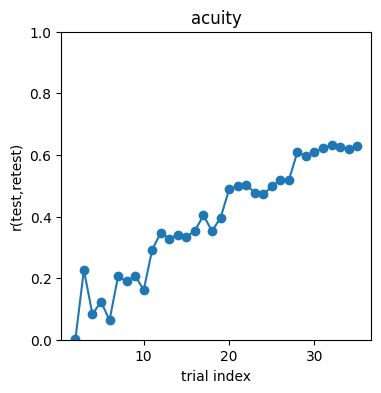

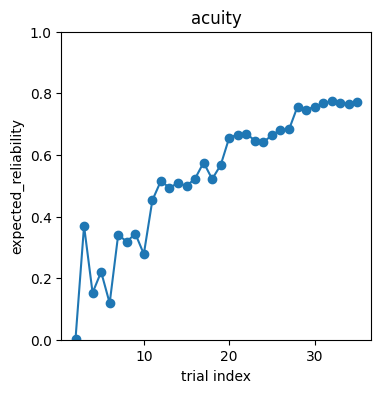

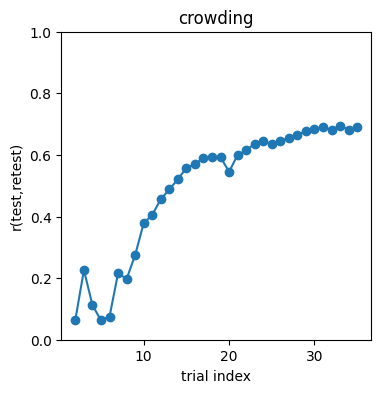

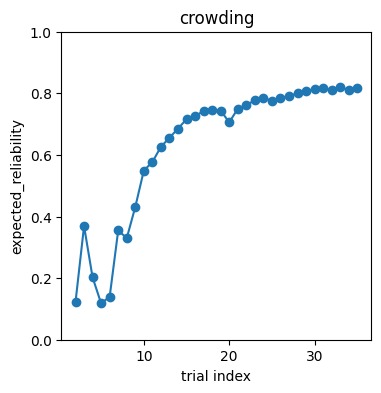

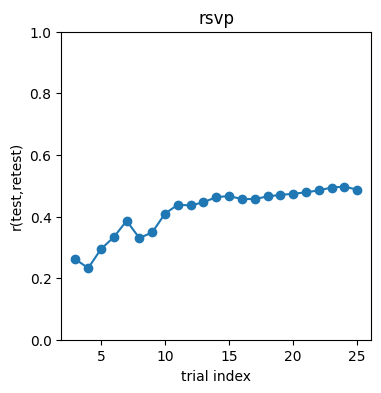

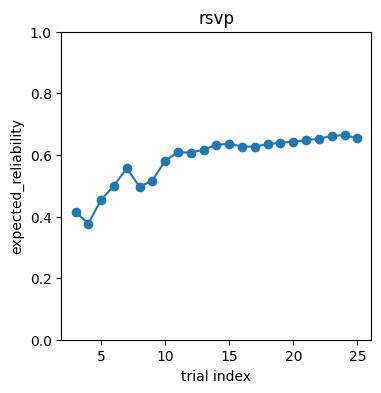

In [32]:
plot_reliability(rel_acuity, "acuity", "r(test,retest)")
plot_reliability(rel_acuity, "acuity", "expected_reliability")

plot_reliability(rel_crowding, "crowding", "r(test,retest)")
plot_reliability(rel_crowding, "crowding", "expected_reliability")

plot_reliability(rel_rsvp, "rsvp", "r(test,retest)")
plot_reliability(rel_rsvp, "rsvp", "expected_reliability")

# Sanity check

In [47]:
tt = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

In [48]:
tt = tt[tt['taskName'] == 'rsvp']

num_trials_required = 24  # 24 trials for original staircase

rsvp_low_trial_ids = (
    tt.loc[
        tt["taskName"].isin(["rsvp"]) & (tt["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

tt = tt[
    ~(
        (tt["taskName"] == "rsvp")
        & (tt["prolificID"].isin(rsvp_low_trial_ids))
    )
].copy()

tt = tt[['prolificID', 'repeat', 'threshold']]
tt_wide = (
    tt
    .pivot_table(index=['prolificID'],
                 columns='repeat',
                 values='threshold')
    .reset_index()
)
test = tt_wide.drop(columns='prolificID')
summarize_task(test)

Number of participants with at least 1 threshold with number of trials < 24: 0


within_subj_variance    0.039204
btw_subj_variance       0.059411
mean                    3.163056
r(test,retest)          0.504108
expected_reliability    0.670308
dtype: float64